In [1]:
!pip install -q torch_geometric
import torch
import numpy as np
from torch_geometric.datasets import Planetoid
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.utils import dense_to_sparse
import networkx as nx
import os
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def load_dataset(name):
    dataset = Planetoid(root=f'/tmp/{name}', name=name)
    data = dataset[0]
    return data

def create_first_view(data):
    # The first view is already provided by the dataset as the citation graph.
    first_view_edge_index = data.edge_index
    return first_view_edge_index

def create_second_view(data, threshold=0.7):
    # Compute cosine similarity between node features
    features = data.x.numpy()
    similarity_matrix = cosine_similarity(features)
    
    # Apply a threshold to construct the graph
    num_nodes = similarity_matrix.shape[0]
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and similarity_matrix[i, j] > threshold:
                edge_index.append([i, j])
    
    second_view_edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return second_view_edge_index

def create_third_view(data, k=5):
    G = nx.Graph()
    features = data.x.numpy()
    
    # Add nodes
    for i in range(features.shape[0]):
        G.add_node(i)
    
    # Add edges based on similarity (without threshold, just top-k similar)
    similarity_matrix = cosine_similarity(features)
    for i in range(similarity_matrix.shape[0]):
        similar_nodes = np.argsort(-similarity_matrix[i, :])[:k]
        for j in similar_nodes:
            if i != j:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    
    # Convert to PyTorch geometric format
    adj_matrix = nx.adjacency_matrix(G).todense()
    third_view_edge_index, _ = dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))
    return third_view_edge_index

# Step 5: Preprocess Dataset
def preprocess_dataset(name):
    data = load_dataset(name)
    
    # Generate the views
    first_view = create_first_view(data)
    second_view = create_second_view(data, threshold=0.7)
    third_view = create_third_view(data, k=5)
    
    processed_data = {
        'first_view': first_view,
        'second_view': second_view,
        'third_view': third_view,
        'features': data.x,
        'labels': data.y,
        'train_mask': data.train_mask,
        'val_mask': data.val_mask,
        'test_mask': data.test_mask
    }

    return processed_data

In [3]:
all_datasets = {}
for dataset_name in ['Cora', 'Citeseer', 'Pubmed']:
    print(f"Processing {dataset_name} dataset...")
    processed_data = preprocess_dataset(dataset_name)
    all_datasets[dataset_name] = processed_data

print("All datasets have been processed and stored in the 'all_datasets' dictionary.")

Processing Cora dataset...


Processing...
Done!


Processing Citeseer dataset...


Processing...
Done!


Processing Pubmed dataset...


Processing...
Done!


All datasets have been processed and stored in the 'all_datasets' dictionary.


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.utils import scatter
import torch.nn.init as init
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import os
import matplotlib.pyplot as plt

In [5]:
class MAGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_views, hidden_dim=16, dropout=0.5):
        super(MAGCN, self).__init__()
        self.num_views = num_views
        self.dropout = dropout

        self.gcn_unfold = torch.nn.ModuleList([
            GCNConv(num_features, hidden_dim) for _ in range(num_views)
        ])
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(self.dropout)
        
        self.batch_norms = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_views)
        ])
        self.attention_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 6),
            torch.nn.Sigmoid(),
            torch.nn.Linear(6, 3),
            torch.torch.nn.Sigmoid(),
            torch.nn.Linear(3, self.num_views),
#             torch.nn.ReLU(),
        )

        # Final GCN layer after merging
        self.gcn_merge = GCNConv(hidden_dim, num_classes)
        self.final_dropout = nn.Dropout(0.3)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, GCNConv):
                init.xavier_uniform_(m.lin.weight)
                if m.lin.bias is not None:
                    init.zeros_(m.lin.bias)

    def graph_gap(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype) + 1  # Degree + self-loop
        # Normalize node features by the degree (mean aggregation)
        deg_inv = deg.pow(-1).view(-1, 1)
        x = deg_inv * x
        # Sum the features from the neighbors
        out = scatter(x[col], row, dim=0, dim_size=x.size(0), reduce='add')
        
        return out

    def forward(self, data):
        # Step 1: Apply GCN to each view
        view_outputs = []
        for i in range(self.num_views):
            x = self.gcn_unfold[i](data.x, data.view_edge_index[i])
#             x = self.batch_norms[i](x)
            x = self.relu(x)
            x = self.dropout_layer(x)
            view_outputs.append(x)

        # Step 2: Apply Graph GAP for each view
        gap_outputs = []
        for i in range(self.num_views):
            gap_output = self.graph_gap(view_outputs[i], data.view_edge_index[i])
            gap_outputs.append(gap_output)

        gap_outputs = torch.stack(gap_outputs, dim=0)  # Shape: (num_views, num_nodes, hidden_dim)

        # Step 3: Compute attention scores
        pooled_gap = torch.mean(gap_outputs, dim=0)  # Shape: (num_nodes, hidden_dim)
        attention_scores = self.attention_mlp(pooled_gap)  # Shape: (num_nodes, num_views)
        
#         attention_scores = self.dropout_layer(attention_scores)

        # Normalize attention scores across views for each node
        attention_scores = F.softmax(attention_scores, dim=1)  # Shape: (num_nodes, num_views)
        # Step 4: Apply attention to the view outputs
        attention_scores = attention_scores.unsqueeze(-1)  # Shape: (num_nodes, num_views, 1)
        weighted_output = torch.sum(attention_scores * gap_outputs.permute(1, 0, 2), dim=1)  # Shape: (num_nodes, hidden_dim)
        weighted_output = self.dropout_layer(weighted_output)

        # Step 5: Merge the views with final GCN
        out = self.gcn_merge(weighted_output, data.view_edge_index[0])  # Use first view's edges for merging
#         out = self.final_dropout(out)
        return F.log_softmax(out, dim=1)


In [6]:

def train_model(model, data, optimizer, epochs=2000, early_stopping_patience=100, model_save_path="best_model.pth"):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Train accuracy
        _, pred_train = out[data.train_mask].max(dim=1)
        correct_train = int((pred_train == data.y[data.train_mask]).sum())
        train_acc = correct_train / int(data.train_mask.sum())

        # Validation step
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])

            # Validation accuracy
            _, pred_val = val_out[data.val_mask].max(dim=1)
            correct_val = int((pred_val == data.y[data.val_mask]).sum())
            val_acc = correct_val / int(data.val_mask.sum())
        
        # Store losses and accuracies
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Acc: {train_acc:.4f}, Val_Loss: {val_loss.item():.4f}, Val_Acc: {val_acc:.4f}')

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, model_save_path)
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

        model.train()
    
    model.load_state_dict(torch.load(model_save_path))
    print(f"Best model loaded from {model_save_path}")

    # Call the plotting function
    return [train_losses, val_losses, train_accuracies, val_accuracies]


def test_model(model, data):
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int((pred[data.test_mask] == data.y[data.test_mask]).sum())
    acc = correct / int(data.test_mask.sum())
    print(f'Test Accuracy: {acc:.4f}')

def load_processed_data_from_dict(dataset_dict):
    return Data(
        x=dataset_dict['features'],
        y=dataset_dict['labels'],
        train_mask=dataset_dict['train_mask'],
        val_mask=dataset_dict['val_mask'],
        test_mask=dataset_dict['test_mask'],
        view_edge_index=[dataset_dict['first_view'], dataset_dict['second_view'], dataset_dict['third_view']]
    )


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot training and validation loss
    plt.figure()
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()


In [7]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

class MAGCNVisualizer:
    def __init__(self, model, data):
        self.model = model
        self.data = data

    def extract_features(self):
        """
        Forward-pass the data through the model and extract the feature representations.
        Returns the pooled gap output which will be used for t-SNE.
        """
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            view_outputs = []
            for i in range(self.model.num_views):
                x = self.model.gcn_unfold[i](self.data.x, self.data.view_edge_index[i])
                x = self.model.relu(x)
                view_outputs.append(x)

            gap_outputs = []
            for i in range(self.model.num_views):
                gap_output = self.model.graph_gap(view_outputs[i], self.data.view_edge_index[i])
                gap_outputs.append(gap_output)

            gap_outputs = torch.stack(gap_outputs, dim=0)  # Shape: (num_views, num_nodes, hidden_dim)
            pooled_gap = torch.mean(gap_outputs, dim=0)  # Shape: (num_nodes, hidden_dim)

        return pooled_gap

    def apply_tsne(self, features, n_components=2, random_state=42):
        """
        Apply t-SNE to the extracted features.
        Returns the 2D t-SNE results.
        """
        tsne = TSNE(n_components=n_components, random_state=random_state)
        tsne_results = tsne.fit_transform(features.cpu().numpy())  # Move data to CPU if using GPU
        return tsne_results

    def plot_tsne(self, tsne_results, labels):
        """
        Plot the t-SNE results using matplotlib and seaborn.
        """
        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x=tsne_results[:, 0], y=tsne_results[:, 1],
            hue=labels,
            palette=sns.color_palette("hsv", len(set(labels))),
            legend="full",
            alpha=0.7
        )
        plt.title('t-SNE of Node Feature Representations (MAGCN)')
        plt.show()

    def visualize(self):
        """
        Full process: extract features, apply t-SNE, and plot the results.
        """
        features = self.extract_features()
        tsne_results = self.apply_tsne(features)
        labels = self.data.y.cpu().numpy()
        self.plot_tsne(tsne_results, labels)

In [10]:
dataset_name = 'Cora'
data = load_processed_data_from_dict(all_datasets[dataset_name])
num_features = data.x.size(1)
num_classes = int(data.y.max()) + 1
hidden_dim = 16
num_views = 3
dropout = 0.5
model = MAGCN(num_features, num_classes, num_views, hidden_dim,    dropout )
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=5e-3)
losses = train_model(model, data, optimizer, epochs=5000, early_stopping_patience=1000)

Epoch 1, Loss: 1.9498, Acc: 0.1286, Val_Loss: 1.8965, Val_Acc: 0.3700
Epoch 101, Loss: 0.2390, Acc: 0.9714, Val_Loss: 0.6517, Val_Acc: 0.8140
Epoch 201, Loss: 0.2289, Acc: 0.9786, Val_Loss: 0.6856, Val_Acc: 0.7860
Epoch 301, Loss: 0.2072, Acc: 0.9571, Val_Loss: 0.6487, Val_Acc: 0.7980
Epoch 401, Loss: 0.2697, Acc: 0.9714, Val_Loss: 0.8131, Val_Acc: 0.7680
Epoch 501, Loss: 0.2145, Acc: 0.9786, Val_Loss: 0.6827, Val_Acc: 0.7900
Epoch 601, Loss: 0.2695, Acc: 0.9357, Val_Loss: 0.6790, Val_Acc: 0.7840
Epoch 701, Loss: 0.2217, Acc: 0.9643, Val_Loss: 0.7432, Val_Acc: 0.7720
Epoch 801, Loss: 0.2084, Acc: 0.9786, Val_Loss: 0.6893, Val_Acc: 0.7860
Epoch 901, Loss: 0.2095, Acc: 0.9571, Val_Loss: 0.6788, Val_Acc: 0.7900
Epoch 1001, Loss: 0.1879, Acc: 0.9786, Val_Loss: 0.7086, Val_Acc: 0.7800
Early stopping triggered.
Best model loaded from best_model.pth


In [11]:
test_model(model, data)

Test Accuracy: 0.8300


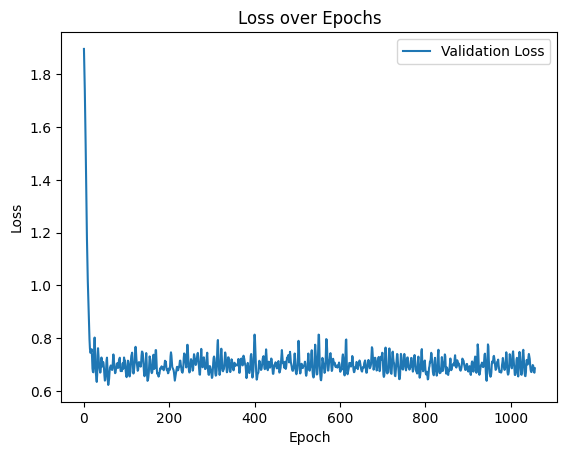

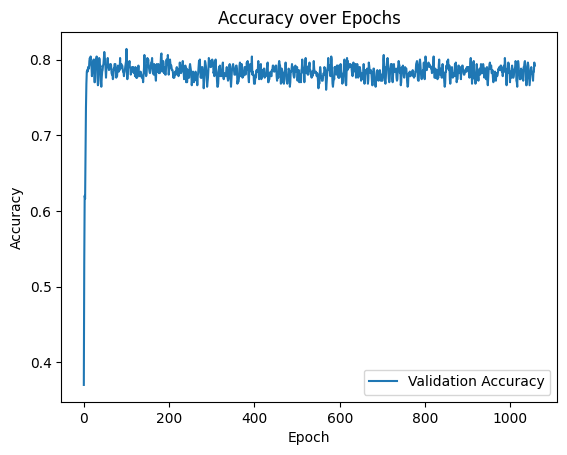

In [12]:
plot_training_metrics(losses[0],losses[1],losses[2],losses[3])

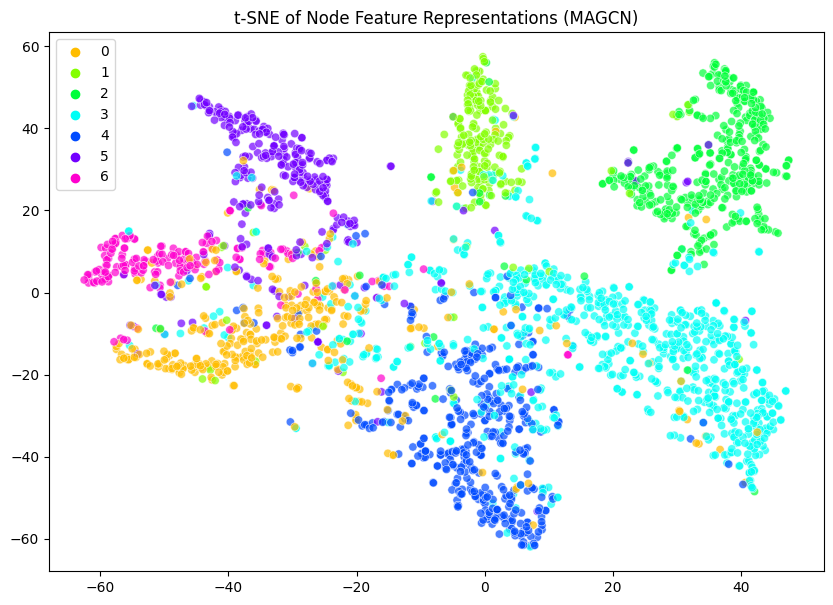

In [10]:
visualizer = MAGCNVisualizer(model, data)
visualizer.visualize()

In [42]:
dataset_name = 'Citeseer'
data = load_processed_data_from_dict(all_datasets[dataset_name])
num_features = data.x.size(1)
num_classes = int(data.y.max()) + 1
hidden_dim = 16
num_views = 3
dropout = 0.5
model = MAGCN(num_features, num_classes, num_views, hidden_dim,dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
losses = train_model(model, data, optimizer, epochs=5000, early_stopping_patience=1000)

Epoch 1, Loss: 1.7937, Acc: 0.1833, Val_Loss: 1.7579, Val_Acc: 0.4800
Epoch 101, Loss: 0.1406, Acc: 0.9917, Val_Loss: 0.9372, Val_Acc: 0.7000
Epoch 201, Loss: 0.1140, Acc: 0.9833, Val_Loss: 0.9499, Val_Acc: 0.6820
Epoch 301, Loss: 0.1271, Acc: 0.9917, Val_Loss: 0.9443, Val_Acc: 0.6740
Epoch 401, Loss: 0.0923, Acc: 0.9917, Val_Loss: 0.9408, Val_Acc: 0.6860
Epoch 501, Loss: 0.1223, Acc: 0.9750, Val_Loss: 0.9502, Val_Acc: 0.6840
Epoch 601, Loss: 0.1416, Acc: 0.9917, Val_Loss: 0.9511, Val_Acc: 0.6740
Epoch 701, Loss: 0.1052, Acc: 0.9917, Val_Loss: 0.9469, Val_Acc: 0.6860
Epoch 801, Loss: 0.1152, Acc: 0.9833, Val_Loss: 0.9697, Val_Acc: 0.6740
Epoch 901, Loss: 0.1164, Acc: 0.9917, Val_Loss: 0.9741, Val_Acc: 0.6740
Epoch 1001, Loss: 0.1208, Acc: 0.9917, Val_Loss: 0.9508, Val_Acc: 0.6800
Epoch 1101, Loss: 0.1023, Acc: 1.0000, Val_Loss: 0.9440, Val_Acc: 0.6820
Epoch 1201, Loss: 0.1268, Acc: 0.9833, Val_Loss: 0.9169, Val_Acc: 0.7020
Epoch 1301, Loss: 0.1091, Acc: 0.9917, Val_Loss: 0.9537, Val_Ac

In [56]:
test_model(model, data)

Test Accuracy: 0.7080


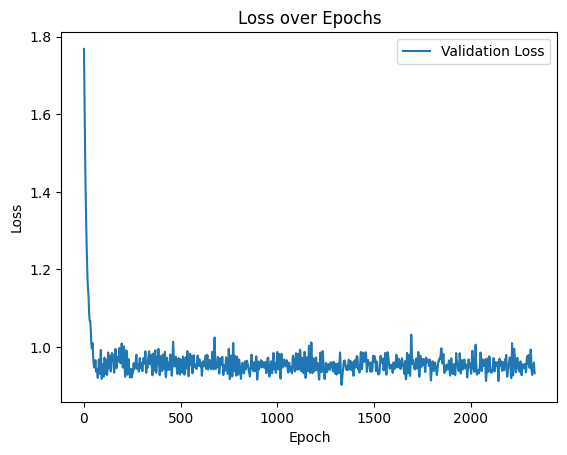

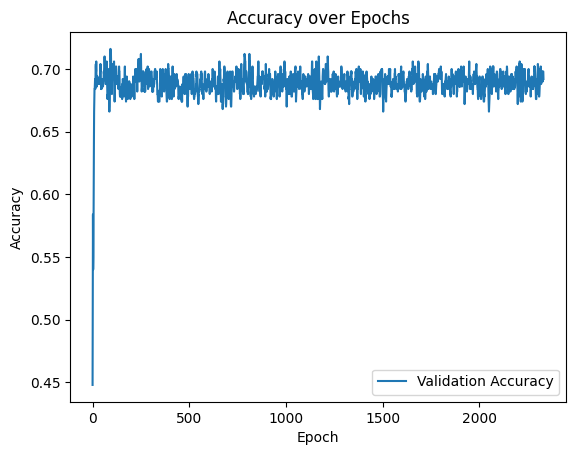

In [15]:
plot_training_metrics(losses[0],losses[1],losses[2],losses[3])

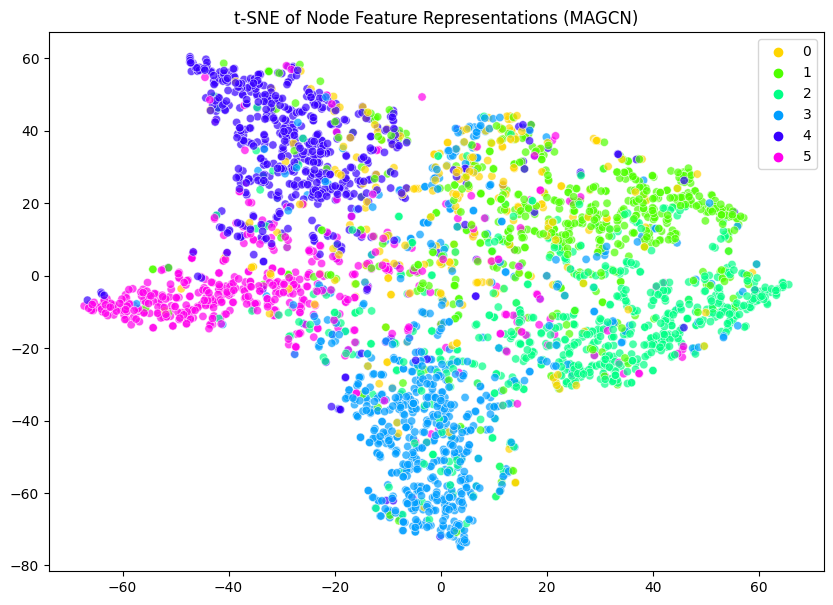

In [18]:
visualizer = MAGCNVisualizer(model, data)
visualizer.visualize()

In [20]:
dataset_name = 'Pubmed'
data = load_processed_data_from_dict(all_datasets[dataset_name])
num_features = data.x.size(1)
num_classes = int(data.y.max()) + 1
hidden_dim = 16
dropout = 0.5
num_views = 3
model = MAGCN(num_features, num_classes, num_views, hidden_dim,dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
losses = train_model(model, data, optimizer, epochs=2000, early_stopping_patience=1000)

Epoch 1, Loss: 1.0991, Acc: 0.2667, Val_Loss: 1.0966, Val_Acc: 0.4800
Epoch 101, Loss: 0.3434, Acc: 0.9667, Val_Loss: 0.6231, Val_Acc: 0.7840
Epoch 201, Loss: 0.2185, Acc: 0.9667, Val_Loss: 0.5746, Val_Acc: 0.7820
Epoch 301, Loss: 0.1658, Acc: 1.0000, Val_Loss: 0.5620, Val_Acc: 0.7860
Epoch 401, Loss: 0.1272, Acc: 0.9667, Val_Loss: 0.5579, Val_Acc: 0.7820
Epoch 601, Loss: 0.1157, Acc: 1.0000, Val_Loss: 0.5616, Val_Acc: 0.7840
Epoch 701, Loss: 0.0893, Acc: 1.0000, Val_Loss: 0.5612, Val_Acc: 0.7740
Epoch 801, Loss: 0.1103, Acc: 0.9667, Val_Loss: 0.5625, Val_Acc: 0.7820
Epoch 901, Loss: 0.1049, Acc: 0.9833, Val_Loss: 0.5671, Val_Acc: 0.7740
Epoch 1001, Loss: 0.0529, Acc: 1.0000, Val_Loss: 0.5756, Val_Acc: 0.7780
Epoch 1101, Loss: 0.1156, Acc: 0.9833, Val_Loss: 0.5828, Val_Acc: 0.7780
Epoch 1201, Loss: 0.0804, Acc: 0.9833, Val_Loss: 0.5794, Val_Acc: 0.7740
Epoch 1301, Loss: 0.0508, Acc: 1.0000, Val_Loss: 0.5874, Val_Acc: 0.7840
Early stopping triggered.
Best model loaded from best_model.pt

In [21]:
test_model(model, data)

Test Accuracy: 0.7880


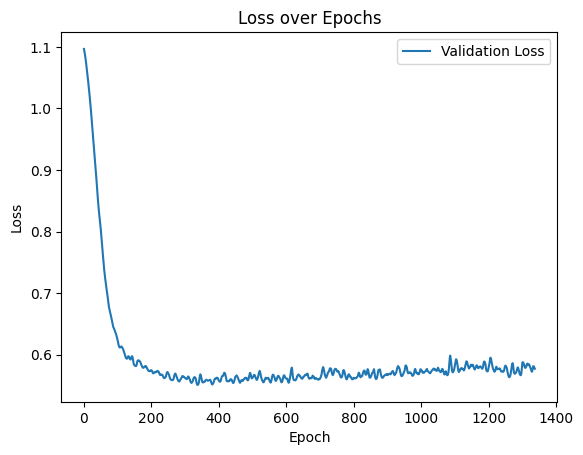

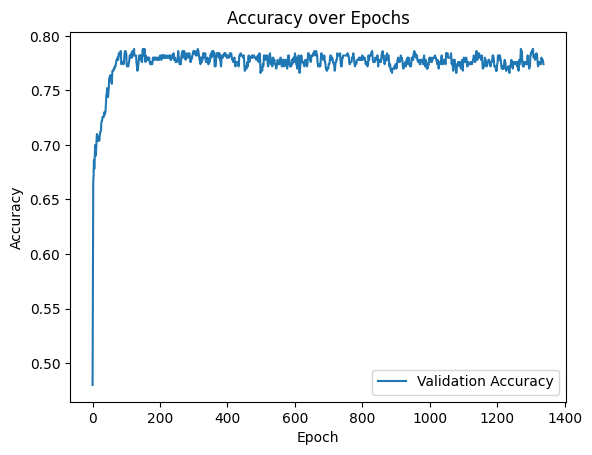

In [22]:
plot_training_metrics(losses[0],losses[1],losses[2],losses[3])

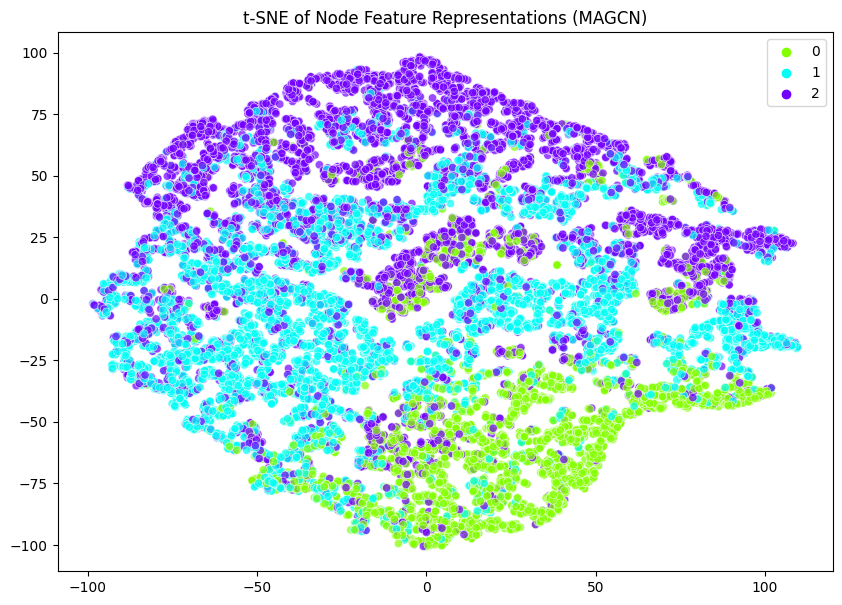

In [14]:
visualizer = MAGCNVisualizer(model, data)
visualizer.visualize()